# Simulation der $T^2$-$Q$-Residuen einer PCA mit multivariat-normalverteilten Daten

Ziel: die korrekte theoretische Verteilung der $T^2$- und $Q$-Residuen bestimmen, um daraus korrekt 95%-Quantile für $T^2$-Q-Plot (bzw. für SIMCA) zu bestimmen.

In [1]:
# import libs
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.linalg import fractional_matrix_power

## Multivariate-normalverteilte Daten (mit Kovarianz!) erzeugen

In [2]:
# create random multivariate normal data

N = int(1e5) # no of data points
M = 5 # no of varibles

X0 = np.random.randn(N,M) # random raw data before trafo (uncorrelated)
Trafo = np.random.randn(M,M) # random transformation
XT = np.matmul(X0,Trafo) # final data set (correlated)

for info, X in {'before': X0, 'after': XT}.items():
    print('Covmat {} transformation:'.format(info))
    display(pd.DataFrame(np.cov(X, rowvar=False)))

# Daten standardisieren
scaler = StandardScaler()
X = scaler.fit_transform(XT)

Covmat before transformation:


,0,1,2,3,4
0,0.996018,0.000325,-0.004954,0.011282,0.002843
1,0.000325,0.998110,-0.000315,-0.001518,0.002327
2,-0.004954,-0.000315,1.003315,-0.001008,-0.003898
3,0.011282,-0.001518,-0.001008,0.996103,0.000365
4,0.002843,0.002327,-0.003898,0.000365,1.001009


Covmat after transformation:


,0,1,2,3,4
0,5.992693,3.769879,1.613716,4.914880,3.466874
1,3.769879,5.592366,2.887370,2.459834,2.227535
2,1.613716,2.887370,3.552218,-0.053131,3.969646
3,4.914880,2.459834,-0.053131,6.543900,-0.129939
4,3.466874,2.227535,3.969646,-0.129939,7.610233


## PCA durchführen

In [3]:
# PCA durchführen
n_components = 2
pca = PCA(n_components=n_components).fit(X)
scores = pca.transform(X)
loadings = pca.components_.T

print('PCA eigenvalues:', pca.explained_variance_)

"""
plt.figure()
lw = 1 # symobl size 

plt.scatter(scores[:, 0], scores[:, 1], alpha=0.8, lw=lw)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA scores (scaled)")

plt.figure()
plt.scatter(loadings[:,0], loadings[:,1])
ax = plt.gca()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA loadings (scaled)")

plt.plot(pca.explained_variance_ratio_ * 100,'.-', label='per component')
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100),'.-', label='cumulative')
plt.xlabel('# of components')
plt.ylabel('explained variance [%]')
plt.ylim([0, 100])
plt.legend()
"""


PCA eigenvalues: [2.83033885 1.4370349 ]


'\nplt.figure()\nlw = 1 # symobl size \n\nplt.scatter(scores[:, 0], scores[:, 1], alpha=0.8, lw=lw)\nplt.legend(loc="best", shadow=False, scatterpoints=1)\nplt.xlabel(\'PC1\')\nplt.ylabel(\'PC2\')\nplt.title("PCA scores (scaled)")\n\nplt.figure()\nplt.scatter(loadings[:,0], loadings[:,1])\nax = plt.gca()\nplt.xlabel(\'PC1\')\nplt.ylabel(\'PC2\')\nplt.title("PCA loadings (scaled)")\n\nplt.plot(pca.explained_variance_ratio_ * 100,\'.-\', label=\'per component\')\nplt.plot(np.cumsum(pca.explained_variance_ratio_ * 100),\'.-\', label=\'cumulative\')\nplt.xlabel(\'# of components\')\nplt.ylabel(\'explained variance [%]\')\nplt.ylim([0, 100])\nplt.legend()\n'

## $T^2$-Residuen berechnen und Quantil bestimmen (empirsich & theoretisch)

0.95-quantile of T2 residuals (exact value from F distr., approx. value from chi2 distr., empirical value): 5.991703960129627 5.991464547107979 6.0064933337142605


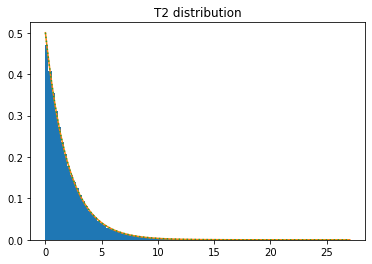

In [4]:
conf=0.95 # confidence level

N, M = X.shape # no of data points, no of variables

# Calculate Hotelling's T-squared
Tsq = np.sum((scores/np.std(scores, axis=0, ddof=1))**2, axis=1) # normalize with unbiased SD (ddof=1)
# compute empirical 95%-quantile for T-squared
Tsq_conf_emp = np.quantile(Tsq, conf)
# compute theoretical 95%-quantile for T-squared from the ppf of the F distribution
df1 = n_components # no of variables
dof = N - 1 # d.o.f.
df2 = dof - df1 + 1
scaling_Tsq_to_F = df2/(df1 * dof)
Tsq_conf =  scipy.stats.f.ppf(q=conf, dfn=df1, dfd=df2) / scaling_Tsq_to_F
# compute approximate theoretical 95%-quantile for T-squared from the ppf of the chi-squared distribution
Tsq_conf_chi2 = scipy.stats.chi2.ppf(q=conf, df=df1)
print("{conf}-quantile of T2 residuals (exact value from F distr., approx. value from chi2 distr., empirical value):".format(conf=conf),
      Tsq_conf, Tsq_conf_chi2, Tsq_conf_emp)
# Plot empirical distribution of Tsq and compare with theoretical distributions
plt.hist(Tsq, bins=100, density=True)
plt.title('T2 distribution')
xvals = np.linspace(0, np.max(Tsq), 1000)
pdf_theoretical = scipy.stats.f.pdf(xvals * scaling_Tsq_to_F, df1, df2) * scaling_Tsq_to_F
pdf_theo_approx = scipy.stats.chi2.pdf(xvals, df1)
plt.plot(xvals, pdf_theoretical, xvals, pdf_theo_approx, ':')
plt.show()

**Zwischenfazit**
* für multivariat-normalverteilte Daten stimmen empirisches und theoretisches Quantil sehr gut überein
* die $T^2$-Werte folgen in diesem Fall wie erwartet der Hotelling-Statistik (die eine skalierte F-Verteilung ist)
* Da $N$ sehr groß ist (viele Beobachtungen), kann statt der F bzw. Hotelling-Statistik auch einfach die $\chi^2$-Verteilung verwendet werden, um das theoretische Quantil zu berechnen

## $Q$-Residuen berechnen und 95%-Quantil berechnen (empirisch & theoretisch)

0.95-quantile of Q residuals (theoretical value, empirical value): 2.4050690865617215 2.3825690798096284


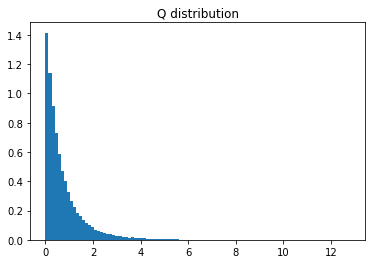

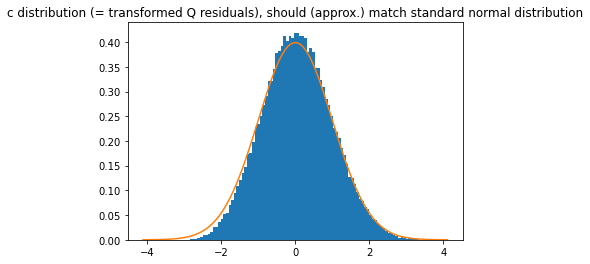

In [5]:
# Calculate Q residuals
#residuals ("errors")
res = X - np.dot(scores,loadings.T)
# Q residuals
Q = np.sum(res**2, axis=1)
# compute empirical 95%-quantile for Q residuals
Q_conf_emp = np.quantile(Q, conf)
# compute theoretical 95%-quantile for Q, according to Jackson and Mudholkar (1979), Eq. (3.4)
lambda_ = np.linalg.eigvals(np.cov(X, rowvar=False))
theta = {i: np.sum(np.power(lambda_[n_components:], i)) for i in [1,2,3]}
h0 = 1 - 2 * theta[1] * theta[3] / (3 * theta[2]**2)
calpha = scipy.stats.norm.ppf(conf)
fraction1 = calpha * np.sqrt(2 * theta[2] * h0**2) / theta[1]
fraction2 = theta[2]*h0*(h0-1) / theta[1]**2
Q_conf = theta[1] * (1 + fraction1 + fraction2)**(1/h0)
print("{conf}-quantile of Q residuals (theoretical value, empirical value):".format(conf=conf),
      Q_conf, Q_conf_emp)

# Plot empirical distribution of Q
plt.hist(Q, bins=100, density=True)
plt.title('Q distribution')

# Plot empirical distribution of c values
# (= transformed Q residuals, cf. Eq. (3.3) in Jackson and Mudholkar)
# and compare with standard normal distribution
c = theta[1] * ((Q/theta[1])**(h0) - 1 - theta[2]*h0*(h0-1)/theta[1]**2)/np.sqrt(2*theta[2]*h0**2)

plt.figure()
plt.hist(c, bins=100, density=True)
xvals = np.linspace(-np.max(abs(c)), +np.max(abs(c)), 1000)
pdf_theoretical = scipy.stats.norm.pdf(xvals, loc=0, scale=1)
plt.plot(xvals, pdf_theoretical)
plt.title('c distribution (= transformed Q residuals), should (approx.) match standard normal distribution')
plt.show()

**Zwischenfazit**
* für multivariat-normalverteilte Daten stimmen empirisches und theoretisches relativ gut überein (die Theorie ist hier auch nur eine Approximation, im Gegensatz zu den $T^2$-Werten)
* die c-Werte (transformierte Q-Werte) folgen näherungsweise einer Standardnormalverteilung

## $T^2$-$Q$-Plot mit theoretischen und empirischen Quantilen

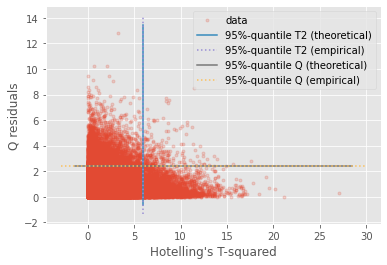

In [6]:
# create T^2-Q-Plot
fig = plt.figure()
with plt.style.context(('ggplot')):
    fig = plt.plot(Tsq, Q, '.', alpha=1./np.log10(N))
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '-')
    plt.plot([Tsq_conf_emp,Tsq_conf_emp],[plt.axis()[2],plt.axis()[3]],  ':')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '-')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf_emp,Q_conf_emp],  ':')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
    plt.legend(['data', '95%-quantile T2 (theoretical)', '95%-quantile T2 (empirical)',
                '95%-quantile Q (theoretical)', '95%-quantile Q (empirical)'])


## Verzweifelter Versuch, auch Q-Residuen durch eine F- oder $\chi^2$-Verteilung zu beschreiben
Das grundsätzliche Problem mit den Q-Werten ist, dass sie aus _nicht_-standardisierten Residuen berechnet werden. (Im Gegensatz zu den Tsq-Werten, bei deren Berechnung die scores standardisiert eingehen.) Dadurch sind die Q-Werte nicht einfach Summen über standardnormalverteilte Größen. Insbesondere sind die Q-Werte abhängig von der (Ko-)Varianzstruktur der Ausgangsdaten. D.h. es kann keine universelle theoretische Verteilung der Q-Werte geben, in die nur die Dimension der Datenmatrix und die Anzahl Komponenten der PCA eingeht, so wie es bei den Tsq-Werten der Fall ist.

Beispiel: Angenommen $k$ Ursprungsvariablen sind perfekt kollinear, d.h. $k$ Eigenwerte der PCA sind 0. Wählt man $n_{components} = M - k$, also $k$ Dimensionen für den Residuenraum, dann liegen allen Datenpunkte perfekt in der PCA-Ebene, d.h. alle Residuen sind 0 und somit $Q=0$. Sind die Daten hingegen nicht perfekt kollinear, ist $Q\ne 0$. D.h. für die gleichen Dimension der Datenmatrix und gleiches $n_{components}$ sind unterschiedliche $Q$-Verteilungen möglich.

Um die $Q$-Werte ähnlich den $T^2$-Werten zu behandeln, müssten man die Residuen also standardisieren. Im Gegensatz zu den Scorses reicht es aber nicht, sie nur durch ihre Std.abw. zu teilen, denn ihre Kovarianz untereinander ist nicht 0. D.h. man muss die Residuen zunächst "drehen" in das Koordiatensystem der PCA, und dann dort Q berechnen. Dann sind aber Q und Tsq sehr eng verwandt, was wahrscheinlich für die Praxis der PCA / SIMCA nicht sinnvoll ist...

Covmat of rotated residuals: [[1.00000000e+00 2.48603626e-17 9.16771833e-15]
 [2.48603626e-17 1.00000000e+00 2.94192504e-15]
 [9.16771833e-15 2.94192504e-15 1.00000000e+00]]


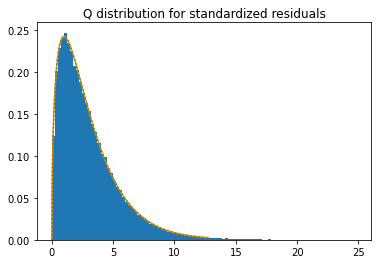

In [7]:
pca_full = PCA(n_components=M).fit(X) # PCA with all components
loadings_full = pca_full.components_.T

res_rotated = np.matmul(res, loadings_full) # rotate residuals to uncorrelated space

res_std = res_rotated[:,n_components:] # pick only residual components (others are zero after rotation)
res_std = res_std / np.std(res_std, axis=0, ddof=1) # standardize residual components

print('Covmat of rotated residuals:', np.cov(res_std, rowvar=False)) # double check: is this a unit matrix?

Qstd = np.sum(res_std**2, axis=1)
plt.hist(Qstd, bins=100, density=True)
plt.title('Q distribution for standardized residuals')

df1 = M - n_components
dof = N - 1 # d.o.f.
df2 = dof - df1 + 1
scaling_Tsq_to_F = df2/(df1 * dof)

xvals = np.linspace(0, np.max(Q), 1000)
pdf_theoretical = scipy.stats.f.pdf(xvals * scaling_Tsq_to_F, df1, df2) * scaling_Tsq_to_F
pdf_theo_approx = scipy.stats.chi2.pdf(xvals, df1)
plt.plot(xvals, pdf_theoretical, xvals, pdf_theo_approx, ':')
plt.show()

**Zwischenfazit**
* dreht man die Residuen in das rotierte Koordinatensystem, sind $n_{components}$ ihrer Komponenten 0
* standardisiert die verbleibenden Komponenten, ist deren Q-Wert (analog zu den Tsq-Werten) Hotelling- bzw. F-verteilt, näherungsweise auch $\chi^2$
* Was bringt's? Wahrscheinlich nicht viel, denn Residuen standardisieren ist für PCA / SIMCA wahrscheinlich nicht sinnvoll, man will ja seine "noise"-Dimensionen nicht künstlich aufblasen indem man durch extrem kleine Std.abw. teilt